<div class="alert alert-block alert-primary" style="text-align: center;">

# 📚 Assignment  
# 🧪 Speech Command Recognition
</div>


Speech command recognition is the task of automatically identifying and classifying spoken commands (such as "turn on the lights" or "play music"). This technology is essential for building voice-activated systems and enhancing user interaction with devices.






<p>
  <img src="https://upload.wikimedia.org/wikipedia/commons/0/04/ChatGPT_logo.svg" alt="ChatGPT Icon" width="28" style="vertical-align:middle; margin-right: 8px;">
  <strong>Use of GenAI: Required Declaration</strong>
</p>

> In this assessment, you **can use** generative AI tools to develop and deepen your understanding of your code. You can use it for:
> - Develop ideas 
> - Employing an audio processing model
> - Debugging code
> - Understanding concepts
>
> You may also use a generative AI assistant to \emph{develop ideas} and to assist with preparing or using an audio model (\eg, \texttt{Wav2Vec2}).  
>
> Examples of acceptable prompts include:
> - “Explain how this works to me”
> - “Help me find the bug in this code”
>
> You **may not use** GenAI to directly generate programs or solutions for submission. Also you cannot use it to code your model
>
> ---
>
> Any use of generative AI must be **explicitly acknowledged** by:
> - Stating the **prompts or questions** you used
> - Describing **how the output was used**
>
> On Moodle, you will find a designated textbox to report this information. This declaration is **mandatory** and ensures transparency in accordance with Monash University's academic integrity guidelines.
>
> ---
>
> ⚠️ **Important:** Failure to disclose permitted use — or using GenAI for prohibited tasks — may be treated as a breach of academic integrity.


## ⚠️ Before You Begin

This notebook contains the skeleton code to attempt the assignment. Feel free to add your own Markdown cells to include additional explanations, notes, or reflections.

Please follow the inline comments and Markdown instructions carefully.

- 🔒 **Do not modify any code blocks explicitly marked as “Do not change.”**  
- 🧠 **Use your own Markdown/Python cells if needed.**
- ✅ **Make sure to run all cells and generate outputs before submission.**

Good luck with the assignment!

## Kaggle Competition: ECSE 4179/5179/6179

Welcome to the Kaggle competition for ECSE 4179/5179/6179! 

### Competition Details

- Competition Link is available on Moodle.
- Registration: You will have been registered with your student email addresses. Please check to see if you can access the assignment.
- Access to Competition Dataset: The competition dataset is available in the Data tab of the Kaggle competition page.
- Competition Rules: The competition rules can be found in the Rules tab of the Kaggle competition page.
- Competition Description: The competition description and task details can be found in the Description tab of the Kaggle competition page.


### Dataset

The competition dataset consists of audio recordings of various command words. The dataset is divided into three folders: Train, Validation, and Test. The Train folder contains audio files for training the models, the Validation folder contains audio files for hyperparameter tuning, and the Test folder contains audio files for final predictions.

### Evaluation
The evaluation metric for this competition is accuracy, which measures the percentage of correctly predicted labels.

### Getting Started

To get started with the competition, please follow these steps:

1. Download the competition dataset.
2. Extract audio features using a model such as Wave2Vec2, and train your models.
3. Tune the hyperparameters using the validation dataset.
4. Make predictions on the test dataset and submit your results.
5. Monitor your leaderboard position and improve your models if necessary.


Good luck and have fun participating in the Kaggle competition!

In [1]:
!pip install transformers

In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # or ":16:8" for smaller workspace

In [4]:
## Libraries. Include if you need more.
import os
import numpy as np ## Numpy is the fundamental building block of understanding tensor (matrices) within Python
import matplotlib.pyplot as plt ## Matplotlib.pyplot is the graphing library that we will be using throughout the semester
# import sys ## Useful to retrieve some system information


# Torch libraries
import torch ## Pytorch is the deep learning library that we will be using
import torch.nn as nn ## Neural network module
import torch.nn.functional as F ## Functional module
import torch.optim as optim ## Optimization module
import math
from copy import deepcopy
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint

from torchmetrics.classification import MulticlassAccuracy

import pandas as pd

from torch.utils.data import Dataset, DataLoader, TensorDataset

# Hugging Face
from transformers import Wav2Vec2Model, Wav2Vec2Processor #depend on your choice

# Audio
import soundfile as sf
import librosa

## Setting seeds for reproducibility. Do NOT change these!
RND_SEED = 42
np.random.seed(RND_SEED)
torch.manual_seed(RND_SEED)
torch.use_deterministic_algorithms(True)


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: cuda


In [5]:

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
#Do not change this cell.

# Define the mapping of prefixes to the ten command labels
label_mapping = {
    "0_": "Yes", "1_": "No", "2_": "Up", "3_": "Down", "4_": "Left",
    "5_": "Right", "6_": "On", "7_": "Off", "8_": "Stop", "9_": "Go"
}

# Define the path to speech_wav folder
dataset_path = "./data/sp_wav"


In [7]:
# Here is an example of how you can process an audio

# Initialize Wav2Vec2 model and processor
wav_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
wav_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

# put the model on the device
wav_model.to(device)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

Loaded: data/trn_00000.wav
Sample rate: 16000 Hz
Duration: 1.00 seconds, shape: (16000,)


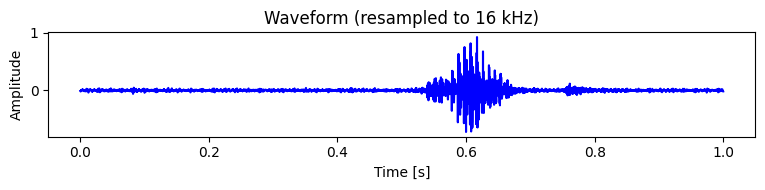

In [33]:
# --- Reading an audio file for Wav2Vec2 ---


# Most speech models (Wav2Vec2, HuBERT, Whisper) expect mono 16 kHz audio
TARGET_SR = 16000

wav_path = "data/trn_00000.wav"  # Example file path
# Load an audio file and resample to 16 kHz
audio, sr = librosa.load(wav_path, sr=TARGET_SR, mono=True)

print(f"Loaded: {wav_path}")
print(f"Sample rate: {sr} Hz")
print(f"Duration: {len(audio)/sr:.2f} seconds, shape: {audio.shape}")

# Optional: visualize the waveform
plt.figure(figsize=(8, 2))
plt.plot(np.linspace(0, len(audio)/sr, len(audio)), audio, color='blue')
plt.title("Waveform (resampled to 16 kHz)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


In [9]:
# Convert the waveform into model-ready tensors
inputs = wav_processor(
    audio,                      # the waveform loaded by librosa
    sampling_rate=sr,           # ensure this matches 16kHz
    return_tensors="pt",        # return PyTorch tensors
)


### 🧠 Understanding Wav2Vec2 Output

When you pass an audio waveform of duration $ t $ seconds to **Wav2Vec2**, the model converts it into a *sequence* of feature vectors rather than a single representation.  More precisely, Wav2Vec2’s convolutional encoder downsamples the time axis by about **a factor of 320**, producing one feature vector roughly every 20 ms of audio.

Thus, if you feed the model a batch of audio waveforms, each of duration $ t $ seconds, you can expect:

- **Input:** a 1-D waveform sampled at 16 kHz  (so the total number of samples is $ 16{,}000 \times t $)
- **Output:** a 3-D tensor of shape  $ (\text{batch\_size}, \text{sequence\_length}, \text{feature\_dim}) $

For a single audio clip, the first dimension is **1** (batch size).  

The second dimension corresponds to **time**, i.e., the number of segments or frames of audio — and the third dimension gives the **feature vector** for each frame.  

To obtain a single global embedding for tasks such as classification, we often take the **mean across the time dimension**, producing one 768-D feature vector per audio clip (for the base Wav2Vec2 model).


### Dataset
To work with the audio data in this project, you will need to download the zip file **speech_wav.zip** from the Data tab in the Kaggle Competeition Page. Once you have downloaded the zip file, extract its contents, and move **speech_wav** folder to the same directory as your Python notebook. In **speech_wav** folder you have three folders: Train, Validation, and Test.

- The **Train** folder contains 18,538 audio files, named trn_00000.wav to trn_18537.wav. You will use these audio files to train your model.

- The **Validation** folder contains 2,577 audio files, named val_00000.wav to val_02576.wav. You will use these audio files to find the best hyperparameters for your model.

- The **Test** folder contains 2,567 audio files, named tst_00000.wav to tst_02566.wav. You will save your model's predictions using these audio files for the final submission.

In addition to the audio files, you will also need the corresponding labels for the training and validation phases. The labels are provided in two CSV files: train.csv and validation.csv.

- The **train.csv** file lists the file names under the **ID** column and their corresponding labels under the **Label** column. For example, an entry in the validation.csv file would look like this:

    ID, Label
    
    val_00001.wav, 3

    This indicates that the file val_00001.wav is labeled as category "3," which corresponds to the command "Down."

The ten command labels are mapped as follows:

- 0: Yes
- 1: No
- 2: Up
- 3: Down
- 4: Left
- 5: Right
- 6: On
- 7: Off
- 8: Stop
- 9: Go

To get started, please download the datasets from the Data tab on the Kaggle page.

In [10]:
train_csv = "C:/Users/Jeff.Chow/OneDrive/Desktop/ECE4179/SCR/scr_train.csv"
val_csv   = "C:/Users/Jeff.Chow/OneDrive/Desktop/ECE4179/SCR/scr_val.csv"
new_test_csv  = "C:/Users/Jeff.Chow/OneDrive/Desktop/ECE4179/assignment/new_test.csv"

data = pd.read_csv(train_csv)
train_name, train_label = data.iloc[:, :-1].values, data.iloc[:, -1].values  # checked and it's matched  #this line is from my previous assignment in ECE2191

data = pd.read_csv(val_csv)
val_name, val_label = data.iloc[:, :-1].values, data.iloc[:, -1].values  # checked and it's matched

data = pd.read_csv(new_test_csv)
test_name, test_label = data.iloc[:, :-1].values, data.iloc[:, -1].values  



# Path where your ImageFolder-style dataset lives
PATH_DATASETS = os.path.expanduser("C:/Users/Jeff.Chow/OneDrive/Desktop/ECE4179/SCR")  # <-- Change if needed
PATH_DATASETS_NEW_TEST = os.path.expanduser("C:/Users/Jeff.Chow/OneDrive/Desktop/ECE4179/assignment")
ROOT_TRAIN = os.path.join(PATH_DATASETS, "train")
ROOT_VAL   = os.path.join(PATH_DATASETS, "val")
ROOT_TEST  = os.path.join(PATH_DATASETS_NEW_TEST, "new_test")

TARGET_SR = 16000


In [11]:
print(train_name[2].item())

trn_00002.wav


In [12]:






training_set = []
for i in range(len(train_name)):
    tr_audio, tr_sr = librosa.load(os.path.join(ROOT_TRAIN, train_name[i].item()), sr=TARGET_SR, mono=True)
    if len(tr_audio) < TARGET_SR:
        tr_audio = librosa.util.fix_length(tr_audio, size=TARGET_SR)
    training_set.append(tr_audio)



VAL_set = []
for i in range(len(val_name)):
    val_audio, tr_sr = librosa.load(os.path.join(ROOT_VAL, val_name[i].item()), sr=TARGET_SR, mono=True)
    if len(val_audio) < TARGET_SR:
        val_audio = librosa.util.fix_length(val_audio, size=TARGET_SR)
    VAL_set.append(val_audio)
    
    
test_set = []
for i in range(len(test_name)):
    test_audio, tr_sr = librosa.load(os.path.join(ROOT_TEST, test_name[i].item()), sr=TARGET_SR, mono=True)
    if len(test_audio) < TARGET_SR:
        test_audio = librosa.util.fix_length(test_audio, size=TARGET_SR)
    test_set.append(test_audio)








In [13]:
X_train = np.stack(training_set, axis=0)  # [N_train, 16000]
X_val   = np.stack(VAL_set, axis=0)       # [N_val,   16000]
X_test  = np.stack(test_set, axis=0)      # [N_test,  16000]

train_t = torch.from_numpy(X_train)     # float32 tensor
val_t   = torch.from_numpy(X_val)
test_t  = torch.from_numpy(X_test)


# print(type(X_train_t))

In [14]:
print("Train DataSET_t size:", train_t.shape)
print("Val DataSET_t size:", val_t.shape)
print("Test DataSET_t size:", test_t.shape)



print("Train label size:", train_label.shape)
print("Val label size:", val_label.shape)
print("Test label size:", test_label.shape)  # this one should be empty 


Train DataSET_t size: torch.Size([18600, 16000])
Val DataSET_t size: torch.Size([2500, 16000])
Test DataSET_t size: torch.Size([2137, 16000])
Train label size: (18600,)
Val label size: (2500,)
Test label size: (2137,)


In [15]:
batch_size = 32 # originally 124, but hit an error of CUDA out of memory.

batch_size_test = 4

train_ds = TensorDataset(train_t.float(), torch.as_tensor(train_label, dtype=torch.long))
val_ds = TensorDataset(val_t.float(), torch.as_tensor(val_label, dtype=torch.long))
test_ds = TensorDataset(test_t.float())



# val_ds = Dataset(train_t.float(), torch.as_tensor(val_label, dtype=torch.long))
# test_ds = Dataset(train_t.float())



train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True) # <-- your code here
val_loader   = DataLoader(val_ds, shuffle=False, batch_size=batch_size, num_workers=2, pin_memory=True) # <-- your code here
test_loader  = DataLoader(test_ds, shuffle=False, batch_size=batch_size_test, num_workers=2, pin_memory=True) # <-- your code here





In [16]:
print("Train DataSET size:", len(train_ds))
print("Val DataSET size:", len(val_ds))
print("Test DataSET size:", len(test_ds))

Train DataSET size: 18600
Val DataSET size: 2500
Test DataSET size: 2137


In [17]:
print("Train DataLOADER size:", len(train_loader))
print("Val DataLOADER size:", len(val_loader))
print("Test DataLOADER size:", len(test_loader))

Train DataLOADER size: 582
Val DataLOADER size: 79
Test DataLOADER size: 535


In [18]:
# The DataLOADER will loop through a batch of indices and provide them to the dataSET one at a time
# and will "batch" together all the datapoints along the "batch dimension" (dim 0) returning a single tensor
train_data_iter = iter(train_loader)
data, labels = next(train_data_iter)
print("Input Data shape", data.shape)
print("Target Data shape", labels.shape)

Input Data shape torch.Size([32, 16000])
Target Data shape torch.Size([32])


## Helper function


In [ ]:
def freeze_model(model, layer_names, freeze_bn=True):
    """
    Freeze all parameters in a CNN model, then selectively unfreeze specified modules.
    Steps:
        1. Freeze every parameter in the model.
        2. Unfreeze the modules listed in `layer_names` (and all their children).
        3. If `freeze_bn=True`, set all BatchNorm2d layers to eval mode and keep
           both their running statistics and affine parameters frozen.
    Args:
        model (nn.Module): The model to modify.
        layer_names (list of str): Exact module names to unfreeze. Must match the
            keys returned by `model.named_modules()`, e.g. ["layer4", "fc"].
        freeze_bn (bool, optional): Whether to keep BatchNorm2d layers frozen
            after unfreezing the target modules. Default is True.
    Raises:
        ValueError: If any of the names in `layer_names` are not found in the model.
    Returns:
        nn.Module: The same model with updated `requires_grad` flags.
    """
    # 1) Freeze EVERYTHING
    for p in model.parameters():
        p.requires_grad = False
    # Build a lookup once (no nested searching per name)
    module_map = dict(model.named_modules())
    # 2) Unfreeze exactly the requested modules (and their children)
    for name in layer_names:
        target = module_map.get(name, None)
        if target is None:
            raise ValueError(f"Layer '{name}' not found. Inspect names via [n for n,_ in model.named_modules()].")
        for p in target.parameters():  # includes children
            p.requires_grad = True
    # 3) Fix BN layers (keep them frozen) if requested
    if freeze_bn:
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()  # freeze running mean/var updates
                if m.affine:
                    m.weight.requires_grad = False
                    m.bias.requires_grad   = False
    return model




def evaluate_model(data_loader, model=None):
    """
    Evaluate a classifier on a dataloader.
    Returns (avg_loss, accuracy) where:
      - avg_loss is the mean cross-entropy over all samples (not just batches)
      - accuracy is overall multiclass accuracy in [0, 1]
    """
    if model is None:
        raise ValueError("model is None")

    criterion = nn.CrossEntropyLoss()
    model.eval()

    total_loss = 0.0
    total_examples = 0
    acc_metric = None  # lazily initialized once we know num_classes

    with torch.inference_mode():
        for images, labels in data_loader:
            images = images.to(device).float()
            labels = labels.to(torch.long).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            bs = labels.size(0)  # batch size
            total_loss += loss.item() * bs      # weight by batch size
            total_examples += bs

            # Initialize accuracy metric once we know the number of classes
            if acc_metric is None:
                num_classes = outputs.shape[1]
                acc_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

            preds = outputs.argmax(dim=1)
            acc_metric.update(preds, labels)

    avg_loss = total_loss / max(total_examples, 1)
    accuracy = acc_metric.compute().item() if acc_metric is not None else 0.0
    return avg_loss, accuracy





def train_model(optimizer, model=None, trn_loader=train_loader, val_loader=val_loader, tst_loader=test_loader, num_epochs=5, scheduler = None):
    if model is None:
        raise ValueError("model is None")

    # here just to double check if I'm using cuda to train or not 
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model = model.to(device)
    print("training on:", device)

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # use when freezing layers
    # optim.Adam(
    # (p for p in model.parameters() if p.requires_grad), lr=lr
    # )
    
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    test_losses, test_accuracies = [], []
    BEST_VAL_ACC = float('-inf')
    BEST_EPOCH_BY_VAL_ACC = -1
    TEST_ACC_AT_BEST_VAL = -1
    best_state_dict = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for images, labels in trn_loader:
    
            images = images.to(device, non_blocking=True).float()
            labels = labels.to(device, dtype=torch.long, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()  
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_size = images.size(0)

            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
            total_samples += batch_size



        avg_loss = total_loss / max(1, len(trn_loader))
        train_losses.append(avg_loss)

        train_acc = running_corrects / max(1, total_samples)
        train_accuracies.append(train_acc)

 
        val_loss, val_acc = evaluate_model(val_loader, model)
        val_losses.append(val_loss);  val_accuracies.append(val_acc)
        scheduler.step(val_loss)

        if val_acc > BEST_VAL_ACC:
            BEST_VAL_ACC = val_acc
            BEST_EPOCH_BY_VAL_ACC = epoch    # the best val acc happened at this epoch 
            
            #TEST_ACC_AT_BEST_VAL, test_cel= eval_loop(test_loader, model, device)
            best_state_dict = deepcopy(model.state_dict())  # copy the weights
        
        # tst_loss, tst_acc = evaluate_model(tst_loader, model)
        # test_losses.append(tst_loss); test_accuracies.append(tst_acc)

        print(f"\nEpoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_loss:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | ")
              #f"Test Loss: {tst_loss:.4f}, Acc: {tst_acc:.4f}")
        

    results_dict = {
        'train_accuracies': train_accuracies,
        'train_loss': train_losses,
        'val_loss': val_losses,
        'val_accuracies': val_accuracies,
        'test_loss': test_losses,
        'test_accuracies': test_accuracies,
        'BEST_EPOCH_BY_VAL_ACC': BEST_EPOCH_BY_VAL_ACC,
        'best model': best_state_dict
    }
    return results_dict





def plotting(logger, figsize=(8,4), title = "", xlabel = "", ylabel = ""):
    plt.figure(figsize=figsize)
    plt.plot(logger)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    
    




## Model

In [20]:



class SelfAttentionPooling(nn.Module):  # this SelfAttentionPooling is adapted from https://gist.github.com/pohanchi/c77f6dbfbcbc21c5215acde4f62e4362
    def __init__(self, d):
        super().__init__()
        self.W = nn.Linear(d, 1)
    def forward(self, H):                 # H: [B, T', D]
        # a = self.w(H).squeeze(-1)         # [B, T']
        # w = a.softmax(dim=1)              # [B, T']
        
        
        att_w = nn.functional.softmax(self.W(H).squeeze(-1), dim=1).unsqueeze(-1)
        utter_rep = torch.sum(H * att_w, dim=1)
        return utter_rep  # [B, D]


class Wave_Linear(nn.Module):
    
# <-- your code here
    def __init__(self, wav_model, num_classes = 10, hidden_layer = 384, p=0.15):
        super().__init__()
        # Create Network
        self.wave_model = wav_model
        # here I want to get the output size of the wave_model, as it is the input for linear model
        features = wav_model.config.hidden_size
        self.attentionpool = SelfAttentionPooling(features)
        
        self.layer_norm = nn.LayerNorm(features) 
        self.linear1 = nn.Linear(features, hidden_layer)
        
        self.Dropout = nn.Dropout(p)
        self.linear2 = nn.Linear(hidden_layer, num_classes)
        
        
    def forward(self, x):
        #with torch.no_grad():       if using fine tuning, don't use it  
        out = self.wave_model(input_values=x)
        H = out.last_hidden_state        # [B, T', 768]
        #feat = H.mean(dim=1)             # simple mean-pool → [B, 768]
        feat = self.attentionpool(H)
        x = self.layer_norm(feat)
        
        logits = self.linear1(x)           # [B, num_classes]
        logits = F.gelu(logits)
        logits = self.Dropout(logits)
        logits = self.linear2(logits)
        return logits
     

## Feature Extraction or Fine Tuning

In [21]:
# Here is an example of how you can process an audio


wav_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
# put the model on the device
wav_model.to(device)

model = Wave_Linear(wav_model, num_classes=10)   # <-- instance, not the class

for name, param in model.named_parameters():
    print(f"Name: {name}, Shape: {param.shape}")




Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name: wave_model.masked_spec_embed, Shape: torch.Size([768])
Name: wave_model.feature_extractor.conv_layers.0.conv.weight, Shape: torch.Size([512, 1, 10])
Name: wave_model.feature_extractor.conv_layers.0.layer_norm.weight, Shape: torch.Size([512])
Name: wave_model.feature_extractor.conv_layers.0.layer_norm.bias, Shape: torch.Size([512])
Name: wave_model.feature_extractor.conv_layers.1.conv.weight, Shape: torch.Size([512, 512, 3])
Name: wave_model.feature_extractor.conv_layers.2.conv.weight, Shape: torch.Size([512, 512, 3])
Name: wave_model.feature_extractor.conv_layers.3.conv.weight, Shape: torch.Size([512, 512, 3])
Name: wave_model.feature_extractor.conv_layers.4.conv.weight, Shape: torch.Size([512, 512, 3])
Name: wave_model.feature_extractor.conv_layers.5.conv.weight, Shape: torch.Size([512, 512, 2])
Name: wave_model.feature_extractor.conv_layers.6.conv.weight, Shape: torch.Size([512, 512, 2])
Name: wave_model.feature_projection.layer_norm.weight, Shape: torch.Size([512])
Name: wave_

In [ ]:
# Since I combine feaature exttraction and linear layer together, I'm gonna use linear probing

# First I freez feature extraction part(wav2Vec2)
model = freeze_model(model, layer_names= ["wave_model.encoder.layers.7", "wave_model.encoder.layers.8", 
                                          "wave_model.encoder.layers.9", 
                                          "attentionpool", "layer_norm", "linear1", "linear2", 
                                          "wave_model.encoder.layers.10", "wave_model.encoder.layers.11"])# <--- add your code here
model = model.to(device)

#sanity check
for n, p in model.named_parameters():
    if p.requires_grad:
        print("TRAIN:", n)
        
        
model.wave_model.train()
model.wave_model.config.apply_spec_augment = False   # <-- turn OFF
model.wave_model.config.mask_time_prob = 0.0
model.wave_model.config.mask_feature_prob = 0.0


model = model.to(device)



# train the model 
num_epoch = 30
#lr = 0.001

classifier_params = list(model.linear1.parameters()) + list(model.layer_norm.parameters()) \
                    + list(model.linear2.parameters()) + list(model.attentionpool.parameters())
                    
unfreez_wave_params = list(model.wave_model.encoder.layers[11].parameters()) + list(model.wave_model.encoder.layers[10].parameters()) \
    + list(model.wave_model.encoder.layers[9].parameters()) + \
    list(model.wave_model.encoder.layers[8].parameters()) + list(model.wave_model.encoder.layers[7].parameters())


optimizer = optim.Adam(
    [
        {"params": classifier_params,    "lr": 5e-4, "weight_decay": 1e-2},
        {"params": unfreez_wave_params, "lr": 5e-6, "weight_decay": 1e-2},
    ]
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)





TRAIN: wave_model.encoder.layers.7.attention.k_proj.weight
TRAIN: wave_model.encoder.layers.7.attention.k_proj.bias
TRAIN: wave_model.encoder.layers.7.attention.v_proj.weight
TRAIN: wave_model.encoder.layers.7.attention.v_proj.bias
TRAIN: wave_model.encoder.layers.7.attention.q_proj.weight
TRAIN: wave_model.encoder.layers.7.attention.q_proj.bias
TRAIN: wave_model.encoder.layers.7.attention.out_proj.weight
TRAIN: wave_model.encoder.layers.7.attention.out_proj.bias
TRAIN: wave_model.encoder.layers.7.layer_norm.weight
TRAIN: wave_model.encoder.layers.7.layer_norm.bias
TRAIN: wave_model.encoder.layers.7.feed_forward.intermediate_dense.weight
TRAIN: wave_model.encoder.layers.7.feed_forward.intermediate_dense.bias
TRAIN: wave_model.encoder.layers.7.feed_forward.output_dense.weight
TRAIN: wave_model.encoder.layers.7.feed_forward.output_dense.bias
TRAIN: wave_model.encoder.layers.7.final_layer_norm.weight
TRAIN: wave_model.encoder.layers.7.final_layer_norm.bias
TRAIN: wave_model.encoder.layers

In [24]:
#training 
results_dict = train_model(optimizer, model, train_loader, val_loader, test_loader, num_epochs=num_epoch, scheduler=scheduler)




training on: cuda

Epoch [1/30] | Train Loss: 0.1883 | Val Loss: 0.1167, Acc: 0.9668 | 

Epoch [2/30] | Train Loss: 0.1750 | Val Loss: 0.1064, Acc: 0.9701 | 

Epoch [3/30] | Train Loss: 0.1605 | Val Loss: 0.1023, Acc: 0.9701 | 

Epoch [4/30] | Train Loss: 0.1525 | Val Loss: 0.1014, Acc: 0.9692 | 

Epoch [5/30] | Train Loss: 0.1474 | Val Loss: 0.1014, Acc: 0.9676 | 

Epoch [6/30] | Train Loss: 0.1459 | Val Loss: 0.0946, Acc: 0.9709 | 

Epoch [7/30] | Train Loss: 0.1439 | Val Loss: 0.0963, Acc: 0.9699 | 

Epoch [8/30] | Train Loss: 0.1396 | Val Loss: 0.0959, Acc: 0.9721 | 

Epoch [9/30] | Train Loss: 0.1385 | Val Loss: 0.0930, Acc: 0.9714 | 

Epoch [10/30] | Train Loss: 0.1348 | Val Loss: 0.0952, Acc: 0.9720 | 

Epoch [11/30] | Train Loss: 0.1302 | Val Loss: 0.0905, Acc: 0.9705 | 

Epoch [12/30] | Train Loss: 0.1246 | Val Loss: 0.0924, Acc: 0.9714 | 

Epoch [13/30] | Train Loss: 0.1245 | Val Loss: 0.0879, Acc: 0.9726 | 

Epoch [14/30] | Train Loss: 0.1320 | Val Loss: 0.0912, Acc: 0.9712 

In [30]:
torch.save(model.state_dict(), "data/task5_model.pth")

[]

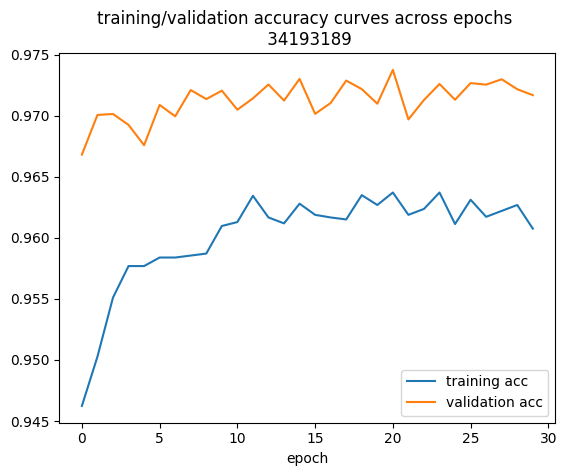

In [25]:
# combine three accu together
plt.title("training/validation accuracy curves across epochs \n 34193189")
plt.xlabel("epoch")
plt.plot(results_dict['train_accuracies'])
plt.plot(results_dict['val_accuracies'])

plt.legend(["training acc", "validation acc"])
plt.plot()

[]

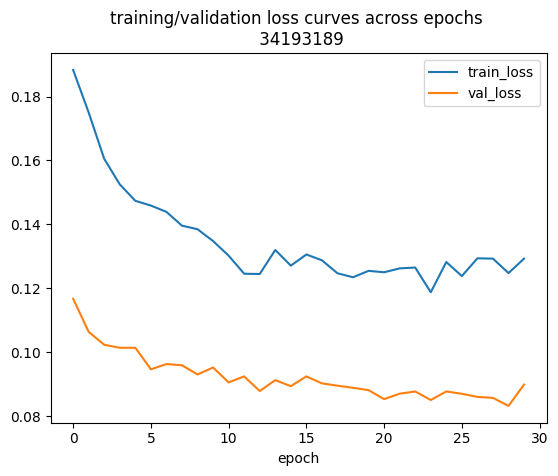

In [26]:
# combine three accu together
plt.title("training/validation loss curves across epochs \n 34193189")
plt.xlabel("epoch")
plt.plot(results_dict['train_loss'])
plt.plot(results_dict['val_loss'])

plt.legend(["train_loss", "val_loss"])
plt.plot()

In [27]:

a = results_dict['BEST_EPOCH_BY_VAL_ACC']
b = results_dict['val_accuracies']
print("BEST_EPOCH_BY_VAL_ACC: ", a)
print("best validation accuracy: ", round(b[a], 4))


BEST_EPOCH_BY_VAL_ACC:  20
best validation accuracy:  0.9737


In [ ]:
# testing 

def test_pred(model, loader, device, use_amp=True):
    model.eval()
    preds = []
    
    with torch.inference_mode():
        for (outputs,) in loader:            
            outputs = outputs.to(device).float()
            #with autocast_ctx:
                
            logits = model(outputs)           # [B, 10]
            preds.append(logits.cpu())
    return torch.cat(preds, dim=0)   # [N, 10]

preds = test_pred(model, test_loader, device)
pred_labels = preds.argmax(dim=1).numpy() 
probs_test  = torch.softmax(preds, dim=1).numpy()


In [ ]:
# Ensure IDs line up with test_loader order
if isinstance(test_name, np.ndarray):
    ids = [str(x[0]) if (isinstance(x, (list, np.ndarray))) else str(x) for x in test_name]
else:
    ids = list(test_name)

# assert len(ids) == len(pred_labels), "IDs and predictions length mismatch!"

out_csv = "Zhao_Zhong_Chow_34193189.csv"  # rename to your real name+ID
with open(out_csv, "w", encoding="utf-8") as f:
    f.write("ID,Label\n")
    for id_str, lbl in zip(ids, pred_labels.tolist()):
        f.write(f"{id_str},{int(lbl)}\n")

print("Saved submission:", out_csv)

Saved submission: Zhao_Zhong_Chow2_34193189.csv
